In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

## Gantt chart of device survival 

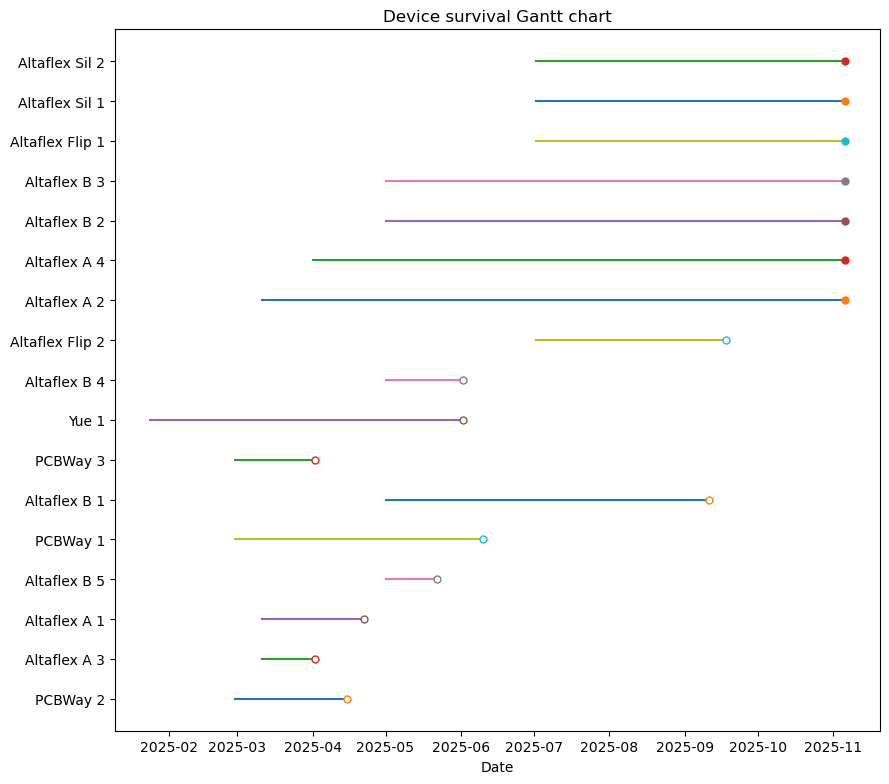

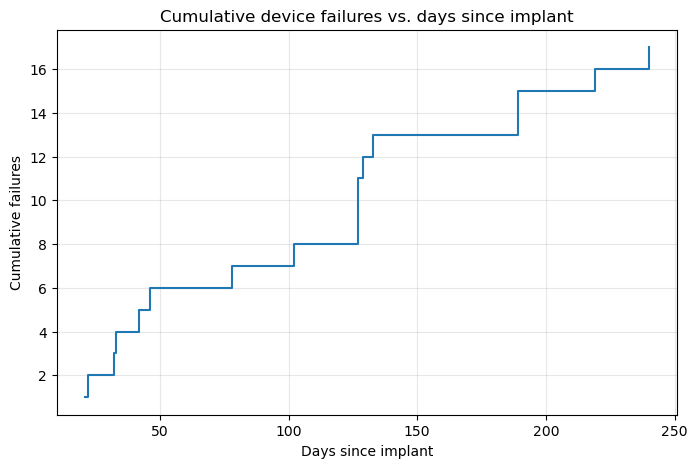

In [ ]:
# Load your Excel or CSV file
df = pd.read_csv("gantt.csv")

# Strip whitespace from column names
df.columns = df.columns.str.strip()
df["implant_date"] = pd.to_datetime(df["Start"])
df["death_date"]   = pd.to_datetime(df["Stop"])
df["status"] = df["Status"]   #will contain value if device is dead


df = df.sort_values(by=["status","Stop"], ascending=[False, True])


# Build plot
plt.figure(figsize=(9, 0.35*len(df)+2))
y = np.arange(len(df))

for i, row in enumerate(df.itertuples()):
    start = row.implant_date
    end   = row.death_date if pd.notna(row.death_date) else pd.Timestamp.today().normalize()
    # line from implant → end (death or last follow-up)
    plt.plot([start, end], [y[i], y[i]], lw=1.5)
    # marker
    # Check if device is alive (no status data)
    is_alive = pd.isna(row.status) or str(row.status).strip() == ""
    if is_alive:
        plt.plot(end, y[i], marker="o", ms=5)          # alive - filled circle
    else:
        plt.plot(row.death_date, y[i], marker="o", ms=5, mfc="white")        # dead - unfilled circle

plt.yticks(y, df["Device"])
plt.title("Device survival Gantt chart")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


## Cumulative device failures vs. days since implant
alive_cutoff = pd.Timestamp.today().normalize()

# time-to-event in days for failures
fail_df = df[(df["status"]!="") & df["death_date"].notna()].copy()
fail_df["ttd_days"] = (fail_df["death_date"] - fail_df["implant_date"]).dt.days

# time-to-censoring in days for alive devices
is_alive = df["status"].isna() | (df["status"].astype(str).str.strip() == "")
alive_df = df[is_alive].copy()
alive_df["ttd_days"] = (alive_df["death_date"].fillna(pd.Timestamp.today().normalize()) - alive_df["implant_date"]).dt.days

# Build step curve for failures
ttd_sorted = fail_df["ttd_days"].sort_values()
cum = pd.DataFrame({"days": ttd_sorted}).assign(cum_fail=lambda x: range(1, len(x)+1))

plt.figure(figsize=(8,5))
plt.step(cum["days"], cum["cum_fail"], where="post", label="Cumulative failures", linewidth=2)

# Add censoring marks for alive devices
if len(alive_df) > 0:
    # Get current cumulative failure count at each censoring time
    for _, row in alive_df.iterrows():
        censor_time = row["ttd_days"]
        # Find cumulative failures up to this point
        cum_fail_at_censor = len(cum[cum["days"] <= censor_time])
        # Add tick mark at censoring time
        plt.plot(censor_time, cum_fail_at_censor, marker="|", ms=10, color="red", 
                markeredgewidth=2, label="Censored (alive)" if _ == alive_df.index[0] else "")

plt.title("Cumulative device failures vs. days since implant")
plt.xlabel("Days since implant")
plt.ylabel("Cumulative failures")
plt.legend()
plt.grid(True, alpha=.3)
plt.show()

## Device survival curve (Kaplan-Meier)

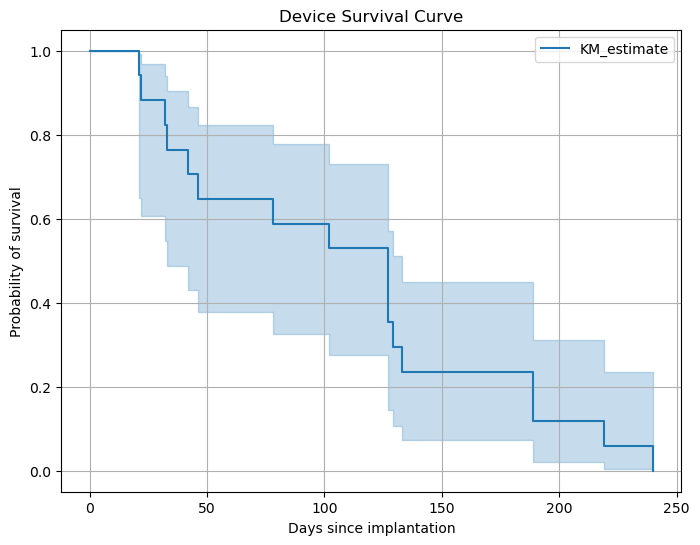

In [10]:
# Load your Excel or CSV file
df = pd.read_csv("gantt.csv")

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Ensure date columns are datetime
df["Start"] = pd.to_datetime(df["Start"])
df["Stop"] = pd.to_datetime(df["Stop"])

# Calculate time-to-event (in days)
today = pd.Timestamp.today()
df["event_time"] = (df["Stop"].fillna(today) - df["Start"]).dt.days

# Create status column: 1 if device failed (Stop is not null), 0 if censored (Stop is null)
df["status"] = df["Stop"].notna().astype(int)

# Initialize Kaplan–Meier model
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(durations=df["event_time"], event_observed=df["status"])

# Plot survival curve
plt.figure(figsize=(8,6))
kmf.plot_survival_function(ci_show=True)
plt.title("Device Survival Curve")
plt.xlabel("Days since implantation")
plt.ylabel("Probability of survival")
plt.grid(True)
plt.show()
